In [3]:
import numpy as np
from numpy import linalg as LA
from scipy.optimize import root
from wolframclient.evaluation import WolframLanguageSession
from wolframclient.language import wl, wlexpr
from itertools import combinations
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors
import csv
import pandas as pd
from scipy.stats import norm

# define matplotlib style
mpl.style.use("classic")
mpl.rc("xtick", labelsize=15)
mpl.rc("ytick", labelsize=15)
mpl.rc("xtick.major", size=14, width=2)
mpl.rc("xtick.minor", size=7, width=2, visible=True)
mpl.rc("ytick.major", size=14, width=2)
mpl.rc("ytick.minor", size=7, width=2, visible=True)
mpl.rc("lines", linewidth=2, markersize=5)
mpl.rc("axes", linewidth=2, labelsize=15, labelpad=2.5)
mpl.rc("legend", fontsize=15, loc="best", frameon=True, numpoints=1)

mpl.rc("font", family="STIXGeneral")
mpl.rc("mathtext", fontset="stix")
mpl.rc("axes", titlesize=20, titlepad=10)

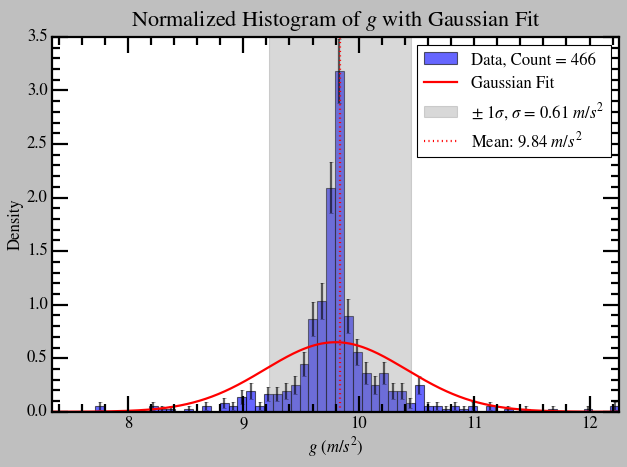

In [92]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas as pd

def plot_histogram_with_fit(data, x_label, y_label, title, png, num_of_bins=100):
    """
    Plot a normalized histogram of the provided data with Poisson error bars,
    a Gaussian fit (using the median and std) and text annotations.
    
    The histogram is normalized so that the total area is 1.
    
    Parameters:
        data (array-like): Data to be plotted (e.g. a column from a DataFrame).
        x_label (str): Label for the x-axis.
        y_label (str): Label for the y-axis.
        title (str): Title of the plot.
        png (str): Filename (without extension) to save the image.
        num_of_bins (int): Number of bins in the histogram.
    """
    gg = np.array(data)
    mean_g = np.mean(gg)
    median_g = np.median(gg)
    std_g = np.std(gg)
    min_g = median_g - 4 * std_g
    max_g = median_g + 4 * std_g
    
    # Compute raw histogram for error calculation and normalized histogram for plotting
    counts_raw, bins = np.histogram(gg, bins=num_of_bins)
    bin_width = bins[1] - bins[0]
    total = gg.shape[0]
    # Normalize counts: density = count / (total * bin_width)
    counts_density = counts_raw / (total * bin_width)
    # Compute Poisson errors on counts and scale to density
    errors_density = np.sqrt(counts_raw) / (total * bin_width)
    
    bin_centers = (bins[:-1] + bins[1:]) / 2

    # Plot normalized histogram (area = 1)
    plt.hist(gg, bins=num_of_bins, alpha=0.6, density=True, label=f"Data, Count = {gg.shape[0]}")
    plt.errorbar(bin_centers, counts_density, yerr=errors_density, fmt='none', 
                 ecolor='black', alpha=0.6, capsize=2)
    
    
    # Create x values and compute Gaussian pdf (which is naturally normalized)
    x = np.linspace(min_g, max_g, 1000)
    gaussian_pdf = norm.pdf(x, loc=median_g, scale=std_g)
    plt.plot(x, gaussian_pdf, color="red", label="Gaussian Fit")

    # Plot std region (mean ± std) and a red dotted line at the mean
    plt.axvspan(mean_g - std_g, mean_g + std_g, color='gray', alpha=0.3, label=rf"± 1$\sigma$, $\sigma$ = {round(std_g, 2)} $m/s^2$")
    plt.axvline(mean_g, color='red', linestyle='dotted', lw=2, label=f"Mean: {round(mean_g, 2)} $m/s^2$")
    
    # Axis labels, title, and text annotations
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.xlim(min_g, max_g)
    
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{png}.png", dpi=300)
    plt.show()

# Example usage:
if __name__ == "__main__":
    df = pd.read_csv("PendulumData.csv")
    data = df["g (m/s2)"][(df["g (m/s2)"] < 15) & (df["g (m/s2)"] > 5)]
    plot_histogram_with_fit(data, r"$g$ ($m/s^2$)", "Density", "Normalized Histogram of $g$ with Gaussian Fit", "PendulumDataHistogram")

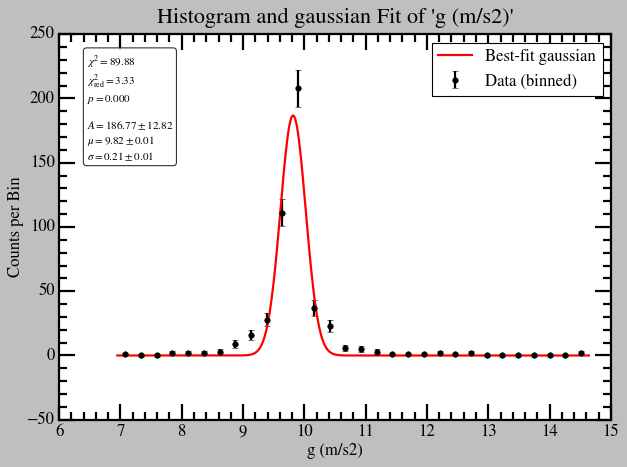

Best-fit parameters:
Amplitude: 186.772 ± 12.817
Mean: 9.816 ± 0.011
Width: 0.206 ± 0.009
Chi-squared: 89.88
Reduced chi-squared: 3.33
Degrees of freedom: 27
p-value: 0.000


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from scipy.stats import chi2

# Define a generic Gaussian function for the fit.
def gaussian(x, amplitude, mean, sigma):
    return amplitude * np.exp(-0.5 * ((x - mean) / sigma) ** 2)

# You can define other fitting functions (e.g., Lorentzian) if needed.
def lorentzian(x, amplitude, mean, gamma):
    return amplitude * (gamma**2 / ((x - mean)**2 + gamma**2))

def poisson(x, amplitude, mean):
    return amplitude * np.exp(-mean) * mean**x / np.math.factorial(x)

def fit_and_plot(data_file, 
                 column_name='g',   # Name of the column to analyze.
                 nbins=30,          # Number of histogram bins.
                 model_func=gaussian,  # Fitting function (e.g., gaussian or lorentzian).
                 initial_guess=None,   # Optional initial guess for [amplitude, mean, width].
                 output_file=None,     # Optional output file for the plot.
                 x_label=None,         # Label for the x-axis; if None, column_name is used.
                 y_label='Counts per Bin',
                 lower_bound=None,     # Lower bound for the x-axis.
                 upper_bound=None):    # Upper bound for the x-axis.
    """
    Loads data from a CSV file, bins the specified column, fits the histogram 
    to a model function, evaluates the fit, and plots the results.
    """
    # --- Load the Data ---
    try:
        data_df = pd.read_csv(data_file)
    except Exception as e:
        raise IOError(f"Error loading file '{data_file}': {e}")
    
    if column_name not in data_df.columns:
        available = data_df.columns.tolist()
        raise ValueError(f"Column '{column_name}' not found in '{data_file}'. Available columns: {available}")
    
    data_values = data_df[column_name].values
    if lower_bound is not None:
        data_values = data_values[data_values >= lower_bound]
    if upper_bound is not None:
        data_values = data_values[data_values <= upper_bound]

    # --- Create the Histogram ---
    counts, bin_edges = np.histogram(data_values, bins=nbins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0
    # Poisson uncertainties: sqrt(counts), ensuring nonzero error estimates.
    uncertainties = np.sqrt(counts)
    uncertainties[uncertainties == 0] = 1.0

    # Set default x-axis label if none provided.
    if x_label is None:
        x_label = column_name

    # --- Initial Fit ---
    # If no initial guess is provided, make a rough estimate:
    if initial_guess is None:
        amplitude_guess = np.max(counts)
        mean_guess = bin_centers[np.argmax(counts)]
        sigma_guess = np.std(data_values)
        initial_guess = [amplitude_guess, mean_guess, sigma_guess]
    
    try:
        popt, pcov = curve_fit(model_func, bin_centers, counts, p0=initial_guess, sigma=uncertainties, absolute_sigma=True)
    except RuntimeError as e:
        raise RuntimeError("Fit did not converge: " + str(e))
    
    # Extract best-fit parameters and their 1-sigma uncertainties.
    perr = np.sqrt(np.diag(pcov))
    amplitude_fit, mean_fit, width_fit = popt

    # --- Evaluate the Fit ---
    model_counts = model_func(bin_centers, *popt)
    chi_squared = np.sum(((counts - model_counts) / uncertainties) ** 2)
    dof = len(counts) - len(popt)  # degrees of freedom
    reduced_chi2 = chi_squared / dof
    p_value = 1 - chi2.cdf(chi_squared, dof)

    # --- Plotting ---
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plot histogram data with error bars.
    ax.errorbar(bin_centers, counts, yerr=uncertainties, fmt='o', label='Data (binned)', color='black')
    
    # Plot the best-fit model over a smooth x-range.
    x_fit = np.linspace(bin_edges[0], bin_edges[-1], 500)
    y_fit = model_func(x_fit, *popt)
    ax.plot(x_fit, y_fit, label=f'Best-fit {model_func.__name__}', color='red', linewidth=2)
    
    # Set axis labels and title.
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(f"Histogram and {model_func.__name__} Fit of '{column_name}'")
    
    # Annotate the plot with fit results.
    annotation_text = '\n'.join((
        r'$\chi^2=%.2f$' % (chi_squared, ),
        r'$\chi^2_{\mathrm{red}}=%.2f$' % (reduced_chi2, ),
        r'$p=%.3f$' % (p_value, ),
        '',
        r'$A=%.2f \pm %.2f$' % (amplitude_fit, perr[0]),
        r'$\mu=%.2f \pm %.2f$' % (mean_fit, perr[1]),
        r'$\sigma=%.2f \pm %.2f$' % (width_fit, perr[2])
    ))
    props = dict(boxstyle='round', facecolor='white', alpha=0.8)
    ax.text(0.05, 0.95, annotation_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=props)
    
    ax.legend()
    plt.tight_layout()
    if output_file is not None:
        plt.savefig(output_file, dpi=300)
    plt.show()

    # --- Print Fit Results ---
    print("Best-fit parameters:")
    print(f"Amplitude: {amplitude_fit:.3f} ± {perr[0]:.3f}")
    print(f"Mean: {mean_fit:.3f} ± {perr[1]:.3f}")
    print(f"Width: {width_fit:.3f} ± {perr[2]:.3f}")
    print(f"Chi-squared: {chi_squared:.2f}")
    print(f"Reduced chi-squared: {reduced_chi2:.2f}")
    print(f"Degrees of freedom: {dof}")
    print(f"p-value: {p_value:.3f}")

# Allow the script to be run directly.
if __name__ == '__main__':
    # Example usage: adjust data_file and column_name as desired.
    data_file = 'pendulumData.csv'
    column_name = 'g (m/s2)'  # Change this if you want to analyze a different column.
    
    # You can also experiment with a different fitting function by, for example,
    # setting model_func=lorentzian and providing an appropriate initial guess.
    fit_and_plot(data_file=data_file, column_name=column_name, nbins=30, model_func=gaussian, lower_bound=5, upper_bound=15, output_file='pendulum_fit.png')